****Data Cleaning****


📄 Summary length:
count    29734.000000
mean       245.091612
std        381.425084
min          3.000000
25%        118.000000
50%        169.000000
75%        344.000000
max      22874.000000
Name: summary_len, dtype: float64


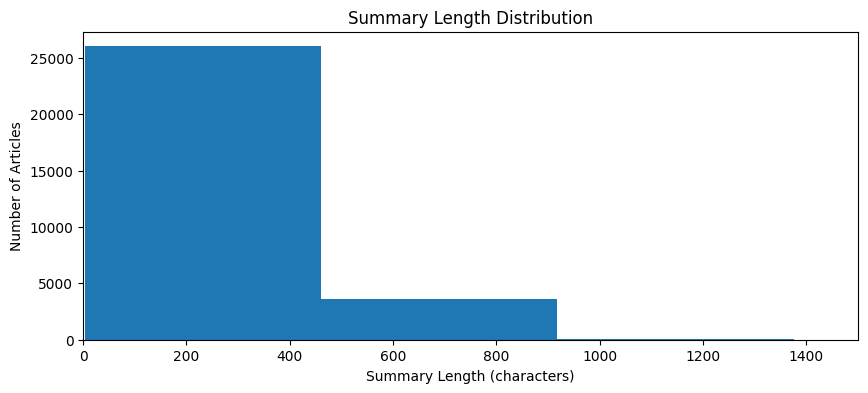


✅ Filtered out summaries ≤ 25th percentile (≤ 118 chars)
Remaining articles: 22279

📁 Saved filtered dataset to:
/Users/sheillaschool/Documents/final/Thesis_PredictingNewsOutdatedness_LogisticDecay/data/main_data/main_dataset.json


In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# === Paths ===
input_path = "/Users/sheillaschool/Documents/final/Thesis_PredictingNewsOutdatedness_LogisticDecay/data/main_data/main_data.json"
output_path = "/Users/sheillaschool/Documents/final/Thesis_PredictingNewsOutdatedness_LogisticDecay/data/main_data/main_dataset.json"

# === Load ===
with open(input_path, "r", encoding="utf-8") as f:
    raw_dict = json.load(f)

df = pd.DataFrame.from_dict(raw_dict, orient="index").reset_index(drop=True)

df["summary_len"] = df["summary"].astype(str).apply(len)

print("\n📄 Summary length:")
print(df["summary_len"].describe())

df["summary_len"].plot(kind="hist", bins=50, title="Summary Length Distribution", figsize=(10, 4), xlim=(0, 1500))
plt.xlabel("Summary Length (characters)")
plt.ylabel("Number of Articles")
plt.show()

q25 = df["summary_len"].quantile(0.25)
df = df[df["summary_len"] > q25].reset_index(drop=True)

print(f"\n✅ Filtered out summaries ≤ 25th percentile (≤ {int(q25)} chars)")
print(f"Remaining articles: {len(df)}")

df.to_json(output_path, orient="index", indent=2, force_ascii=False)
print(f"\n📁 Saved filtered dataset to:\n{output_path}")


In [ ]:
import json
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# === Load ===
input_path = "/Users/sheillaschool/Documents/final/Thesis_PredictingNewsOutdatedness_LogisticDecay/data/main_data/main_dataset.json"
with open(input_path, "r", encoding="utf-8") as f:
    raw_dict = json.load(f)

df = pd.DataFrame.from_dict(raw_dict, orient="index").reset_index(drop=True)


def normalize_text(text):
    text = str(text).lower().strip()
    text = re.sub(r"\s+", " ", text)
    return text

df["body_norm"] = df["body"].apply(normalize_text)
df["summary_norm"] = df["summary"].apply(normalize_text)
df["concat_norm"] = df["body_norm"] + " " + df["summary_norm"]


df["is_exact_duplicate"] = df.duplicated(subset=["body_norm", "summary_norm", "date"], keep=False)
exact_duplicates_df = df[df["is_exact_duplicate"]].copy()

tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
tfidf_matrix = tfidf.fit_transform(df["concat_norm"])

cos_sim = cosine_similarity(tfidf_matrix)
np.fill_diagonal(cos_sim, 0)

threshold = 0.99
near_dup_pairs = np.argwhere(cos_sim > threshold)

seen = set()
near_dup_indices = set()
for i, j in near_dup_pairs:
    if (i, j) not in seen and (j, i) not in seen:
        seen.add((i, j))
        near_dup_indices.update([i, j])

df["is_near_duplicate"] = df.index.isin(near_dup_indices)
near_duplicates_df = df[df["is_near_duplicate"]].copy()

output_path = "/Users/sheillaschool/Documents/final/Thesis_PredictingNewsOutdatedness_LogisticDecay/data/add/duplicate_detection.xlsx"
with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    exact_duplicates_df.to_excel(writer, sheet_name="Exact Duplicates", index=False)
    near_duplicates_df.to_excel(writer, sheet_name="Near Duplicates", index=False)

print(f"✅ Saved to Excel with {len(exact_duplicates_df)} exact and {len(near_duplicates_df)} near duplicates:")
print(output_path)


✅ Saved to Excel with 5172 exact and 5561 near duplicates:
/Users/sheillaschool/Documents/final/Thesis_PredictingNewsOutdatedness_LogisticDecay/data/add/duplicate_detection.xlsx


In [ ]:
import json
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


input_path = "/Users/sheillaschool/Documents/final/Thesis_PredictingNewsOutdatedness_LogisticDecay/data/main_data/main_dataset.json"
output_path = "/Users/sheillaschool/Documents/final/Thesis_PredictingNewsOutdatedness_LogisticDecay/data/main_data/main_dataset.json"

with open(input_path, "r", encoding="utf-8") as f:
    raw_dict = json.load(f)

df = pd.DataFrame.from_dict(raw_dict, orient="index").reset_index(drop=True)


def normalize_text(text):
    text = str(text).lower().strip()
    text = re.sub(r"\s+", " ", text)
    return text

df["body_norm"] = df["body"].apply(normalize_text)
df["summary_norm"] = df["summary"].apply(normalize_text)
df["concat_norm"] = df["body_norm"] + " " + df["summary_norm"]


df["is_exact_duplicate"] = df.duplicated(subset=["body_norm", "summary_norm", "date"], keep=False)
df["is_exact_duplicate_except_first"] = df.duplicated(subset=["body_norm", "summary_norm", "date"], keep="first")


tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
tfidf_matrix = tfidf.fit_transform(df["concat_norm"])

cos_sim = cosine_similarity(tfidf_matrix)
np.fill_diagonal(cos_sim, 0)

threshold = 0.99
near_dup_pairs = np.argwhere(cos_sim > threshold)

seen = set()
near_dup_indices = set()
for i, j in near_dup_pairs:
    if (i, j) not in seen and (j, i) not in seen:
        seen.add((i, j))
        near_dup_indices.update([i, j])


near_dup_mask = df.index.isin(list(near_dup_indices))
first_of_near_dup = df[near_dup_mask].drop_duplicates(subset="concat_norm", keep="first").index
remove_near_dup_idx = set(near_dup_indices) - set(first_of_near_dup)


drop_idx = set(df[df["is_exact_duplicate_except_first"]].index).union(remove_near_dup_idx)
df_cleaned = df.drop(index=drop_idx).reset_index(drop=True)


df_cleaned.to_json(output_path, orient="index", indent=2, force_ascii=False)

print(f"\n🧹 Cleaned dataset saved to:\n{output_path}")
print(f"🗑️ Removed {len(drop_idx)} duplicates (exact and near)")
print(f"✅ Final article count: {len(df_cleaned)}")



🧹 Cleaned dataset saved to:
/Users/sheillaschool/Documents/final/Thesis_PredictingNewsOutdatedness_LogisticDecay/data/main_data/main_dataset.json
🗑️ Removed 4075 duplicates (exact and near)
✅ Final article count: 18204


In [ ]:
import json
import pandas as pd
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

input_path = "/Users/sheillaschool/Documents/final/Thesis_PredictingNewsOutdatedness_LogisticDecay/data/main_data/main_dataset.json"
output_json_path = "/Users/sheillaschool/Documents/final/Thesis_PredictingNewsOutdatedness_LogisticDecay/data/main_data/main_dataset.json"
removed_excel_path = "/Users/sheillaschool/Documents/final/Thesis_PredictingNewsOutdatedness_LogisticDecay/data/add/non_english_removed.xlsx"

with open(input_path, "r", encoding="utf-8") as f:
    raw_dict = json.load(f)

df = pd.DataFrame.from_dict(raw_dict, orient="index").reset_index(drop=True)

DetectorFactory.seed = 0

def detect_lang(text):
    try:
        return detect(str(text))
    except LangDetectException:
        return "unknown"

lang = df["body"].apply(detect_lang)

df_en = df[lang == "en"].copy()
df_non_en = df[lang != "en"].copy()

df_en.to_json(output_json_path, orient="index", indent=2, force_ascii=False)

df_non_en.to_excel(removed_excel_path, index=False)

print(f"✅ English-only dataset saved to:\n{output_json_path}")
print(f"🗑️ Non-English articles ({len(df_non_en)}) saved to:\n{removed_excel_path}")


✅ English-only dataset saved to:
/Users/sheillaschool/Documents/final/Thesis_PredictingNewsOutdatedness_LogisticDecay/data/main_data/main_dataset.json
🗑️ Non-English articles (982) saved to:
/Users/sheillaschool/Documents/final/Thesis_PredictingNewsOutdatedness_LogisticDecay/data/add/non_english_removed.xlsx


In [ ]:
import re
import pandas as pd

input_path = "/Users/sheillaschool/Documents/final/Thesis_PredictingNewsOutdatedness_LogisticDecay/data/main_data/main_dataset.json"
output_path = "/Users/sheillaschool/Documents/final/Thesis_PredictingNewsOutdatedness_LogisticDecay/data/main_data/main_dataset.json"

df = pd.read_json(input_path, orient="index")
df.reset_index(drop=True, inplace=True)

def remove_image_tag(text):
    return re.sub(r"\[Image \d+ of \d+\]", "", str(text), flags=re.IGNORECASE).strip()

def remove_location_prefix(text):
    return re.sub(r"^[A-Z\s\-]+,\s?[A-Z][A-Za-z\.]*\s?\((.*?)\)?\s?[–-]\s?|^[A-Z\s\-]+,\s?[A-Z][A-Za-z\.]*\s?[–-]\s?", "", str(text)).strip()

df["title"] = df["title"].apply(remove_image_tag)
df["summary"] = df["summary"].apply(remove_image_tag).apply(remove_location_prefix)
df["body"] = df["body"].apply(remove_image_tag)

df.to_json(output_path, orient="index", indent=2, force_ascii=False)

print(f"✅ Cleaned and saved to:\n{output_path}")


✅ Cleaned and saved to:
/Users/sheillaschool/Documents/final/Thesis_PredictingNewsOutdatedness_LogisticDecay/data/main_data/main_dataset.json


In [5]:
import re
import pandas as pd

input_path = "/Users/sheillaschool/Documents/final/Thesis_PredictingNewsOutdatedness_LogisticDecay/data/main_data/main_dataset.json"
output_path = "/Users/sheillaschool/Documents/final/Thesis_PredictingNewsOutdatedness_LogisticDecay/data/main_data/main_dataset.json"

df = pd.read_json(input_path, orient="index")
df.reset_index(drop=True, inplace=True)

def clean_html_unicode(text):
    text = str(text)
    text = re.sub(r"<[^>]+>", " ", text)  # remove HTML tags
    text = re.sub(r"&nbsp;|&amp;|&quot;|&#\d+;|8217;", "'", text)  # unicode replacements
    text = re.sub(r"[\n\r\t]+", " ", text)  # newlines/tabs
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["title"] = df["title"].apply(clean_html_unicode)
df["summary"] = df["summary"].apply(clean_html_unicode)
df["body"] = df["body"].apply(clean_html_unicode)

df.to_json(output_path, orient="index", indent=2, force_ascii=False)

print(f"✅ Removed HTML/unicode noise and saved to:\n{output_path}")


✅ Removed HTML/unicode noise and saved to:
/Users/sheillaschool/Documents/final/Thesis_PredictingNewsOutdatedness_LogisticDecay/data/main_data/main_dataset.json


**Data Enrichment**

In [6]:
import json
import pandas as pd
import re

input_path = "/Users/sheillaschool/Documents/final/Thesis_PredictingNewsOutdatedness_LogisticDecay/data/main_data/main_dataset.json"
output_path = "/Users/sheillaschool/Documents/final/Thesis_PredictingNewsOutdatedness_LogisticDecay/data/main_data/main_dataset.json"

with open(input_path, "r", encoding="utf-8") as f:
    raw_dict = json.load(f)

df = pd.DataFrame.from_dict(raw_dict, orient="index").reset_index(drop=True)

def minimal_normalize(text):
    text = str(text)
    text = re.sub(r"[^\w\s.,!?;:'\"()\-–—]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["title_normalized"] = df["title"].apply(minimal_normalize)
df["summary_normalized"] = df["summary"].apply(minimal_normalize)

df.to_json(output_path, orient="index", indent=2, force_ascii=False)

print(f"✅ Saved enriched dataset with normalized title/summary to:\n{output_path}")


✅ Saved enriched dataset with normalized title/summary to:
/Users/sheillaschool/Documents/final/Thesis_PredictingNewsOutdatedness_LogisticDecay/data/main_data/main_dataset.json


In [5]:
import json
import pandas as pd
from datetime import datetime


FILE_PATH = "/Users/sheillaschool/Documents/final/Thesis_PredictingNewsOutdatedness_LogisticDecay/data/main_data/main_dataset.json"
DATE_FORMAT = "%Y-%m-%d"


with open(FILE_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame.from_dict(data, orient="index")
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"])


search_dates = pd.date_range(df["date"].min(), df["date"].max())


results = []

for ref_date in search_dates:
    df["t_days"] = (ref_date - df["date"]).dt.days

    bin_0 = df[(df["t_days"] >= 0) & (df["t_days"] < 10)].shape[0]
    bin_10 = df[(df["t_days"] >= 10) & (df["t_days"] < 30)].shape[0]
    bin_30 = df[(df["t_days"] >= 30) & (df["t_days"] < 60)].shape[0]
    bin_60 = df[(df["t_days"] >= 60) & (df["t_days"] < 90)].shape[0]
    bin_90 = df[df["t_days"] >= 90].shape[0]

    results.append((ref_date, bin_0, bin_10, bin_30, bin_60, bin_90))


results_df = pd.DataFrame(results, columns=[
    "reference_date", "bin_0", "bin_10", "bin_30", "bin_60", "bin_90"
])


results_df = results_df.sort_values(by=["bin_0", "bin_10"], ascending=False).reset_index(drop=True)


print("📌 Top Reference Dates:")
print(results_df.head())




📌 Top Reference Dates:
  reference_date  bin_0  bin_10  bin_30  bin_60  bin_90
0     2024-11-14    586     182       0       0    7313
1     2025-02-09    580     941    1501    1555    7900
2     2025-02-12    575     969    1489    1525    8081
3     2025-02-10    573     951    1511    1533    7956
4     2024-12-11    571     984     587       0    7313


In [7]:
import pandas as pd

input_path = "/Users/sheillaschool/Documents/final/Thesis_PredictingNewsOutdatedness_LogisticDecay/data/main_data/main_dataset.json"
output_path = "/Users/sheillaschool/Documents/final/Thesis_PredictingNewsOutdatedness_LogisticDecay/data/main_data/main_dataset.json"

df = pd.read_json(input_path, orient="index")
df.reset_index(drop=True, inplace=True)

ref_date = pd.to_datetime("2025-02-09")
df["date"] = pd.to_datetime(df["date"], errors="coerce")

df = df[df["date"] <= ref_date].copy()
df["t"] = (ref_date - df["date"]).dt.days

def assign_bin(t):
    if t < 10:
        return "fresh"
    elif t < 30:
        return "recent"
    elif t < 60:
        return "middle_age"
    elif t < 90:
        return "old"
    else:
        return "very_old"

df["t_bin"] = df["t"].apply(assign_bin)
df["date"] = df["date"].dt.strftime("%Y-%m-%d")

df.to_json(output_path, orient="index", indent=2, force_ascii=False)

print(f"✅ Saved dataset with 't' and 't_bin' to:\n{output_path}")
print(f"🗑️ Articles after 2025-02-09 were removed. Remaining: {len(df)}")


✅ Saved dataset with 't' and 't_bin' to:
/Users/sheillaschool/Documents/final/Thesis_PredictingNewsOutdatedness_LogisticDecay/data/main_data/main_dataset.json
🗑️ Articles after 2025-02-09 were removed. Remaining: 12477
